In [2]:
import time
import os
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import seaborn as sns

In [3]:
# defining import functions for mask and nib files

def getmask(name):
    mask_im = nib.load("masks/"+name)
    mask = mask_im.get_fdata()
    return mask

def nibim(name, subj="02"):
    files_normed = f'subj{subj}/1stLevel_nob0_norm_MVPA_trial_smooth/'
    beta_path = files_normed + name
    nimage = nib.load(beta_path)
    return nimage.get_fdata()

In [4]:
def get_c_lb(data):    
    temp=data.copy()
    temp["unpacked"] = temp["acc"].apply(lambda x: [y.replace("[","").replace("]","").strip().rstrip() for y in x.split(" ") if y != ''])
    temp["unpacked"] = temp["unpacked"].apply(lambda x: [y for y in x if y != ''])
    temp["unpacked"] = temp["unpacked"].apply(lambda x: [y for y in x if y != '.'])

    svm_scores = pd.DataFrame(temp["unpacked"].to_list(), columns=[1,2,3,4], dtype=float)
    mean_acc = svm_scores.mean(axis=1)
    std_acc = svm_scores.std(axis=1)
    
    # compute the confidence intervals lower bounds
    alpha = 0.95
    n=4
    
    # Define our z
    ci = alpha + (1-alpha)/2
    
    #Lower Interval, where n is sample siz
    c_lb = mean_acc - norm.ppf(ci)*((std_acc/(n**0.5)))
    c_ub = mean_acc  + norm.ppf(ci)*((std_acc/(n**0.5)))
    return c_lb

In [5]:
def brain_plot(data, original=True, create_figure=True):
    ## plot the accuracy as a brain shape
    plt.rcParams["figure.figsize"] = [10,10]
    if create_figure:
        fig = plt.figure()
    else:
        fig = plt.gcf()
    ax = fig.gca(projection='3d')
    # brain
    if original:
        img=ax.scatter(data.x, data.y, data.z,c=data.Acc_lb, cmap='Reds',alpha=0.5)
    else:
        img=ax.scatter(data.x, data.y, data.z,c=data.Acc_lb, cmap='Reds',alpha=0.5, marker="s",  s=50)
    cbar=fig.colorbar(img,fraction=0.025)
    cbar.set_label('Accuracy ', rotation=270, fontsize = 15, labelpad=20)
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return None

In [6]:
!ls *.txt

result_log.txt
subj02_svm_result_log_WedJun10950582022.txt
subj02_svm_result_log_WedJun11058162022.txt
subj07_svm_result_log_WedJun11035002022.txt
svm_result_log.txt
svm_result_log_FriMay271339312022.txt


In [7]:
# Reading result files that were created by "beta_image_classification.ipynb"
subj02_res = "subj02_svm_result_log_WedJun11058162022.txt"
subj07_res = "subj07_svm_result_log_WedJun11035002022.txt"
s02_res = pd.read_csv(subj02_res, header=None)[[1,3]]
s07_res = pd.read_csv(subj07_res, header=None)[[1,3]]
s02_res.columns = ["area", "acc"]
s07_res.columns = ["area", "acc"]
s02_res["c_lb"] = get_c_lb(s02_res)
s07_res["c_lb"] = get_c_lb(s07_res)
print(s02_res.shape)
print(s07_res.shape)

(247, 3)
(247, 3)


In [8]:
s02_res["c_lb"].mean()
s07_res["c_lb"].mean()

0.4471765523213662

### Score comparison
Below I compare prediction scores per brain region for two subjects

Athough the best accuracy scores are similar for both, the regions do not overlap. For example, no brain region is in top 15 best predictions in both participants




Text(0.5, 1.0, 'Subject comparison for Brain Atlas')

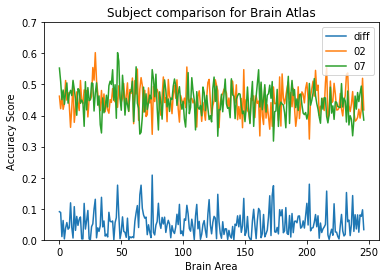

In [9]:
plt.plot(abs(s02_res["c_lb"] - s07_res["c_lb"]), label="diff")
plt.plot(s02_res["c_lb"], label="02")
plt.plot(s07_res["c_lb"], label="07")
plt.ylim([0,.7])
plt.legend()
plt.xlabel("Brain Area")
plt.ylabel("Accuracy Score")
plt.title("Subject comparison for Brain Atlas")

Text(0.5, 1.0, 'Subject comparison for Brain Atlas')

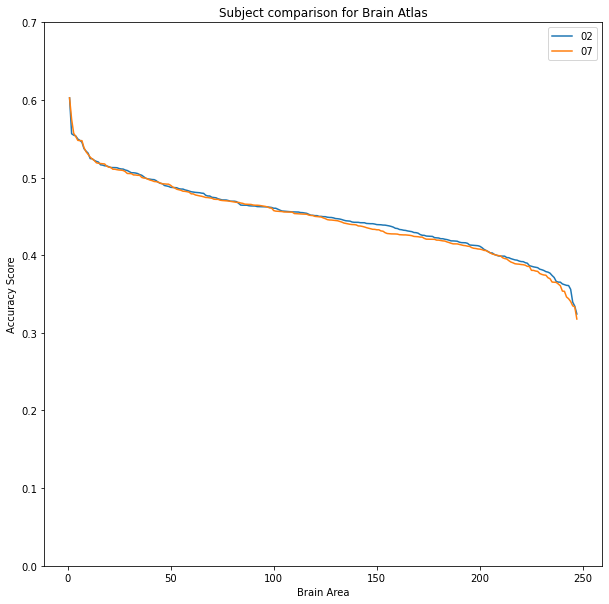

In [64]:

plt.plot(range(1,248), s02_res["c_lb"].sort_values(ascending=False), label="02")
plt.plot(range(1,248), s07_res["c_lb"].sort_values(ascending=False), label="07")
plt.ylim([0,.7])
plt.legend()
plt.xlabel("Brain Area")
plt.ylabel("Accuracy Score")
plt.title("Subject comparison for Brain Atlas")

In [62]:
len(s02_res["c_lb"].sort_values())

247

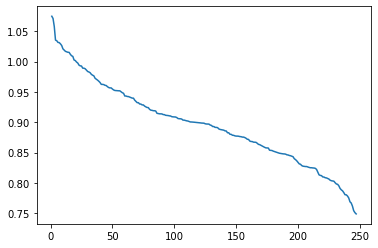

In [10]:
analysis_df = s02_res.copy()
analysis_df["sum"] = s02_res["c_lb"] + s07_res["c_lb"]
analysis_df = analysis_df.sort_values("sum", ascending=False)
plt.plot(range(1,248),analysis_df["sum"])

In [11]:
analysis_df.head()

,area,acc,c_lb,sum
29,29.0,[0.60416667 0.60416667 0.625 0.61702128],0.602538,1.074618
48,48.0,[0.47916667 0.54166667 0.54166667 0.55319149],0.495983,1.071004
27,27.0,[0.54166667 0.625 0.58333333 0.61702128],0.554553,1.057787
185,185.0,[0.66666667 0.52083333 0.52083333 0.70212766],0.508991,1.035269
43,43.0,[0.52083333 0.58333333 0.47916667 0.53191489],0.486812,1.034292


In [ ]:
# correlation analysis
s02 = np.array(s02_res["c_lb"].to_list())
s07 = np.array(s07_res["c_lb"].to_list())

In [ ]:
np.corrcoef(s02,s07)[0,1]

In [13]:
permtest = [np.corrcoef(np.random.permutation(s02),s07)[0,1] for x in range(500)]
np.mean(permtest)
# So the correlation is still better than random

NameError: name 's02' is not defined

In [14]:
top15_07 = s07_res.sort_values("c_lb", ascending=False)[:15]
top15_02 = s02_res.sort_values("c_lb", ascending=False)[:15]

In [15]:
# No area is in both top 15
set(top15_07["area"]).intersection(set(top15_02["area"]))

set()

Text(0, 0.5, 'Prediction Score')

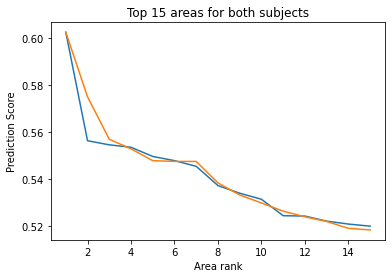

In [16]:
x_vals = range(1,16)
plt.plot(x_vals, top15_02["c_lb"], label="02")
plt.plot(x_vals, top15_07["c_lb"], label="07")
plt.title("Top 15 areas for both subjects")
plt.xlabel("Area rank")
plt.ylabel("Prediction Score")

In [17]:
def prepare_atlas_data(result_file):
    # This function maps the prediction scores back to the voxel coordinates to be used in brain plot funciton
    atlas = getmask("output_atlas.nii")
    key = result_file["area"].to_list()
    value = result_file["c_lb"].to_list()
    atlas_map = dict(zip(key,value))
    x, y, z = np.where(atlas>-1)
    atlas_data=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])
    atlas_data['value']=np.transpose(atlas).flatten('F')
    atlas_data['value']=round(atlas_data['value'])
    atlas_data["Acc_lb"] = atlas_data["value"].apply(lambda x: atlas_map[x])
    atlas_data = atlas_data.query("value > 0.")
    
    return atlas_data, atlas_map

In [18]:
atlas_dat_02, map_02 = prepare_atlas_data(s02_res)
atlas_dat_07, map_07 = prepare_atlas_data(s07_res)
map_02.update({0.0:0.})
map_07.update({0.0:0.})

### Visualisation

Below are some visualisations of prediction accuracy per brain region

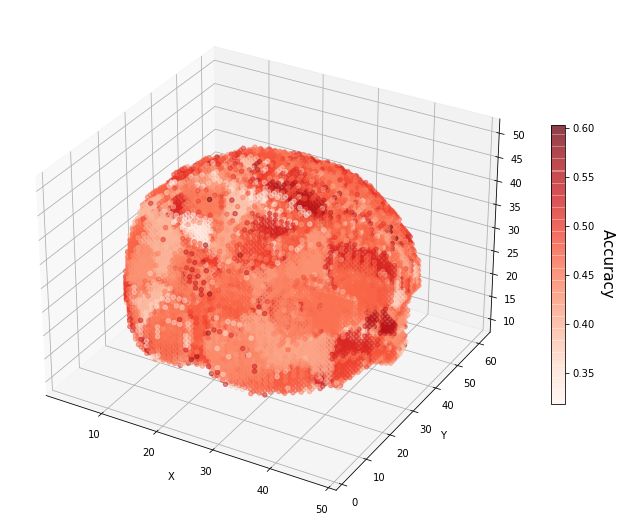

In [19]:
# entire brain with accuracy mapped to different regions
brain_plot(atlas_dat_07)

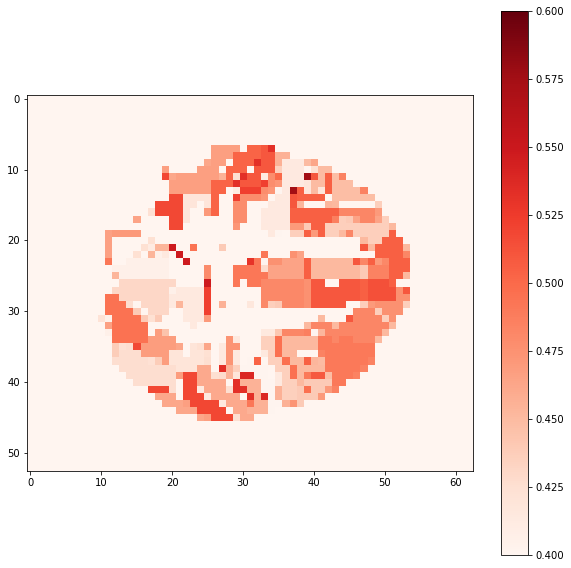

In [58]:
# If we want to map the accuracy to the atlas mask
# TBelow is the mask colored in prediction accuracy (not the original brain)
    
mask = getmask("output_atlas.nii").round()
my_func = lambda x: map_07[x]
vfunc = np.vectorize(my_func)
plt.imshow(vfunc(mask[:,:,40]), cmap="Reds",vmin=0.4, vmax=0.6)
#plt.imshow(vfunc(mask[:,:,40]), cmap="Reds")
plt.colorbar()

In [57]:
"""mask_im = nib.load("masks/output_mask.nii")
mask = mask_im.get_fdata()

mask = getmask("output_atlas.nii").round()
output = vfunc(mask[:,:,:])

# to save this 3D (ndarry) numpy use this
ni_img = nib.Nifti1Image(output, mask.affine, mask.header, )

nib.save(ni_img, 'masks/output_atlas.nii')"""

In [38]:
def compare_plot(section=40):
    plt.figure(figsize=(12,8))
    # If we want to map the accuracy to the atlas mask
    plt.subplot(1,2,1)
    mask = getmask("output_atlas.nii").round()
    my_func = lambda x: map_02[x]
    vfunc = np.vectorize(my_func)
    #plt.imshow(vfunc(mask[:,:,40]), cmap="Reds",vmin=0, vmax=1)
    plt.imshow(vfunc(mask[:,:,section]), cmap="Reds")
    plt.title("subj 2")
    
    plt.subplot(1,2,2)
    mask = getmask("output_atlas.nii").round()
    my_func = lambda x: map_07[x]
    vfunc = np.vectorize(my_func)
    #plt.imshow(vfunc(mask[:,:,40]), cmap="Reds",vmin=0, vmax=1)
    plt.imshow(vfunc(mask[:,:,section]), cmap="Reds")
    plt.title("subj 7")
    #plt.colorbar()
    
    return None

### Participant comparison
Below we see a slize through both subject 2 and 7 brain

The brain areas do not evidently overlap between peope (here color means again prediction accuracy, the darker the better)


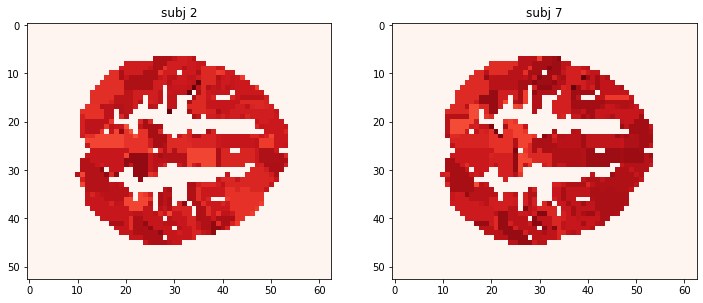

In [39]:
compare_plot()

### Plot top 15 regions
Below we plot the top 15 regions for both subjects. The regions don't look very coherent. This might be the true regions or an artifact/error of our data processing this is something wed have to investigate further before seriously analysing more data

Text(0.5, 0.92, 'Top 15 regions for subject 7')

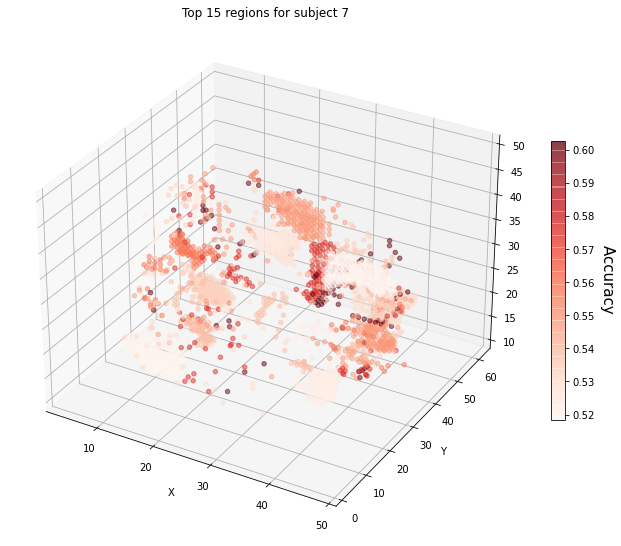

In [23]:
brain_plot(atlas_dat_07[atlas_dat_07["value"].isin(top15_07["area"])])
plt.title("Top 15 regions for subject 7")

Text(0.5, 0.92, 'Top 15 regions for subject 2')

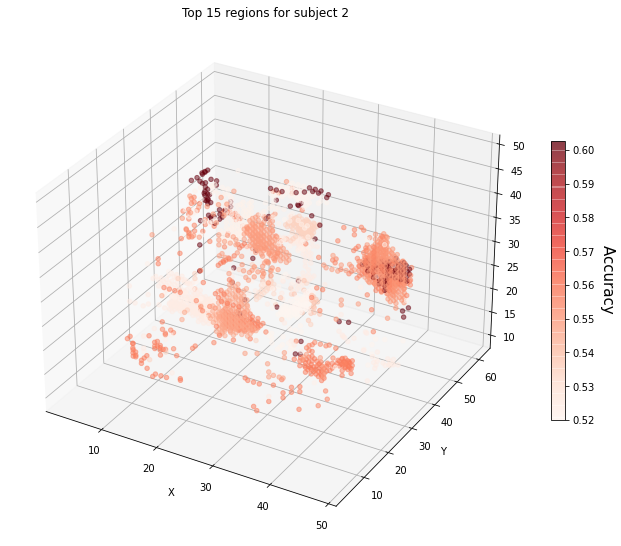

In [24]:
brain_plot(atlas_dat_02[atlas_dat_02["value"].isin(top15_02["area"])])
plt.title("Top 15 regions for subject 2")